# Where can you eat safely in Chigago : an analysis based on the inspections reports from the Chicago department of Public Health's Food Protection Program.

## 1. Introduction

  The Chicago department of Public Health’s Food Protection Program provides a database which contains the information from inspection reports of restaurants and other food establishments in Chicago from 2010 to the present. It contains many informations about the establishments, like their type of facility (grocery stores, restaurants, coffee shop, …) and their locations. Many informations about the violations listed are also provided in the database, like the description of the findings that caused them and the reason that invoked the staff from the program to led an inspection.

**The main research question is : Where can you eat safely in Chicago ?**

The adjective `safely` is chosen wisely because it has multiple meanings : you can eat in a `safe` way making sure that the establishment where you go respects particular hygiene rules, but also that the place is `safe` according to the crime rate of its district.

  To begin, it has been decided that the analysis of the data will be done temporally. Indeed, the field of restoration is known to be in a constant evolution : each year, many establishments are opening while other are closing or changing of owner - especially in big cities. 
This is why the different calculations and comparisons will be done by year. To answer the main question about where to eat in Chicago, the answer will be given based on the latest data.
Also, a map visualization seems to be a good solution to diplay the results, as the analysis is spatio-temporal. 


### Hygiene Score

The hygiene of the public and private food establishments listed in the dataset will be calculated using on a `hygiene score` based on the different violations reported and the final result of the inspection. In order to compare the places to eat by delimited zones, a mean will be computed by community area.
  
**Questions :** 

*Are their significant differences of hygiene scores between the community areas ?*

*How is the evolution over time ?*
  

### A little study about Management

Two datasets have been found, which contain the owner's et license's informations of Chicago establishments. It would be interesting to merge it with the first dataset in order to study the trends regarding the management of the establishments.
  
**Questions :**

*Is their a relation between the number of establishments that an owner has and the hygiene scores obtained ?*

*In which way a change of owner changes the hygiene score of an establishment ?*


### Crime Score

The Chicago Crime Report can be used in order to compute a `crime score` for each community area, following the same principle than in the first point. This way, it will be possible to compare the crime and hygiene scores according to the community areas.

**Questions :**

*Criminology domain*


### Limits :

An important point is to pay intention to the number of inspected establishments compared to the total number of establishments. It is certain than the variations of this ratio between the community areas has an impact on the results. An explanation of the variations should be purposed.
In order to give a complete answer to the main research question, the uninspected establishments have to be taken into account.
   

### Definitions :

Hygiene Rules : Food Code Rules

Community Area :


The purpose of the project is to help the consumer to easily choose where to eat in Chicago and to provide them an interactive and intuitive way to browse the different places offered to them. Also, it could help the Chicago department of Public Health’s Food Protection Program to adapt their methods relying on the situation described by the findings of the analysis (for example, if a prevention program should be proposed for a specific area or type of facility).


---

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests as req
from bs4 import BeautifulSoup
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

## 2. Preprocessing


First a quick look at how the dataset is organized. 

In [2]:
eat_seat = pd.read_csv('food-inspections.csv',sep=',') #creation of the dataframe
eat_seat.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2352683,CHIPOTLE MEXICAN GRILL,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,CHICAGO,IL,60613.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,2352734,CHILI'S T-I,CHILI'S (T1-B14),34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,...,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,Risk 1 (High),2900 W 63RD ST,CHICAGO,IL,60629.0,...,Not Ready,NaN,41.779190,-87.695892,"{'latitude': '-87.69589237398256', 'longitude'...",NaN,NaN,NaN,NaN,NaN


In [3]:
eat_seat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196825 entries, 0 to 196824
Data columns (total 22 columns):
Inspection ID                 196825 non-null int64
DBA Name                      196825 non-null object
AKA Name                      194367 non-null object
License #                     196808 non-null float64
Facility Type                 192057 non-null object
Risk                          196756 non-null object
Address                       196825 non-null object
City                          196686 non-null object
State                         196783 non-null object
Zip                           196775 non-null float64
Inspection Date               196825 non-null object
Inspection Type               196824 non-null object
Results                       196825 non-null object
Violations                    144559 non-null object
Latitude                      196135 non-null float64
Longitude                     196135 non-null float64
Location                      196135 n

The dataset contains :
- 196'825 entries
- 22 columns (listed above)

### 2.1 Columns Cleaning

### Duplicates management

To begin, it is primary to check if there are duplicates and, if so, decide how to handle them.

In [4]:
duplicates = eat_seat[eat_seat.duplicated(subset=None, keep=False)]
duplicates.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
9932,2286181,YATAI,YATAI,2641287.0,Restaurant,Risk 1 (High),6230 N BROADWAY,CHICAGO,IL,60660.0,...,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.995461,-87.660580,"{'latitude': '-87.66057971349507', 'longitude'...",NaN,NaN,NaN,NaN,NaN
9935,2286112,PILSEN BREAKFAST & GRILL,PILSEN BREAKFAST & GRILL,2340664.0,Restaurant,Risk 1 (High),1454 W 18TH ST,CHICAGO,IL,60608.0,...,Out of Business,NaN,41.857947,-87.663537,"{'latitude': '-87.66353726681123', 'longitude'...",NaN,NaN,NaN,NaN,NaN
9944,2286143,CABANA BAR,CABANA BAR,2636260.0,Liquor,Risk 3 (Low),5342 N CUMBERLAND AVE,CHICAGO,IL,60656.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.976805,-87.836761,"{'latitude': '-87.83676096082264', 'longitude'...",NaN,NaN,NaN,NaN,NaN


It is not realistic that two rows contain the exact same cells : two inspections cannot happen at the same time, the explanation is that one is the duplicate of the other.
Considering this postulate, we can drop the duplicates. 

In [5]:
eat_seat = eat_seat.drop_duplicates()

In [6]:
len(eat_seat)

196676

### Missing and useless values

Now, we want to see which values are missing.

In [7]:
eat_seat.isnull().sum()

Inspection ID                      0
DBA Name                           0
AKA Name                        2457
License #                         17
Facility Type                   4768
Risk                              69
Address                            0
City                             139
State                             42
Zip                               50
Inspection Date                    0
Inspection Type                    1
Results                            0
Violations                     52234
Latitude                         689
Longitude                        689
Location                         689
Historical Wards 2003-2015    196676
Zip Codes                     196676
Community Areas               196676
Census Tracts                 196676
Wards                         196676
dtype: int64

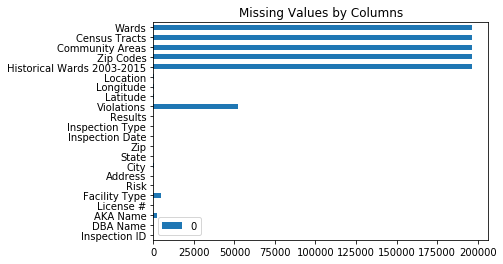

In [8]:
preview = pd.DataFrame(eat_seat.isnull().sum()).plot.barh(title = 'Missing Values by Columns')

As we can see, the columns `Historical Wards 2003-2015`, `Zip Codes`, `Community Areas`, `Census Tracts` and `Wards` are empty and will be dropped.

We will only be using the `DBA Name` (the name under which the establishment is doing business ; DBA = doing business as), so we drop the `AKA Name` column too.

Also, we will use the `Latitude` and `Longitude` in our analysis, so we can drop de `Location`, `Zip`, `City` and `State` columns too. `Address` column is kept because it can help us to notice some inconsistencies.

In [9]:
eat_seat = eat_seat.drop(columns = ['AKA Name','Historical Wards 2003-2015', 'Zip Codes', 'Community Areas',\
                                    'Census Tracts', 'Location', 'Wards', 'City', 'State', 'Zip'])
eat_seat.head(2)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,2019-12-04T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381
1,2352734,CHILI'S T-I,34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,2019-12-04T00:00:00.000,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428


#### Assistants' comments :
•	If you want to cast columns to a certain type, prefer

pandas.to_numeric

**J'ai essayé mais ça n'enlève pas le .0 qui est notre seul objectif maintenant, du coup petit fonction qui retourne ce qu'on veut. Mais ça joue pas je sais pas pourquoi**
 

same for using findall (pandas.Series.str.findall)

### Type Casting

In order to standardize the data, the numbers in the `License` column are converted into integer.

In [10]:
eat_seat['License #'] = pd.to_numeric(eat_seat['License #'], downcast= 'integer')

In [11]:
def nbestethic(nb) :
    try :
        return int(nb)
    except :
        print(nb)
        return nb

In [12]:
eat_seat['License #'] = eat_seat['License #'].apply(nbestethic)
eat_seat.head(2)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,Risk 1 (High),1025 W ADDISON ST,2019-12-04T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381
1,2352734,CHILI'S T-I,34169.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,2019-12-04T00:00:00.000,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428


### Non-defined licenses numbers

There are also missing license numbers, corresponding to the *nan* printed in the last output. The following Dataframe displays them with their respective DBA Name.

In [13]:
names_of_missing = pd.DataFrame(eat_seat['DBA Name'][eat_seat['License #'].isnull()]) 
names_of_missing

,DBA Name
8243,ST. DEMETRIOS GREEK ORTHODOX CHURCH
24791,ST. DEMETRIOS GREEK ORTHODOX CHURCH
41765,ST. DEMETRIOS GREEK ORTHODOX CHURCH
67315,ST. DEMETRIOS GREEK ORTHODOX CHURCH
87192,ST. DEMETRIOS GREEK ORTHODOX CHURCH
112646,ST. DEMETRIOS GREEK ORTHODOX CHURCH
115136,ARGENTINA FOODS
129892,ST. DEMETRIOS GREEK ORTHODOX CHURCH
149547,ST. DEMETRIOS GREEK ORTHODOX CHURCH
152943,OLD ST. PATRICK'S CHURCH


In order to resolve this problem, we search if there are other establishments with the same DBA Name so that, if so, we can attribute their license number to the non-defined license ones.

In [14]:
eat_seat[eat_seat['DBA Name'].isin(names_of_missing)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude


**No establishment** found with the same DBA Name. 



We have then searched in the database containing the *business licenses* details but there is not entry in it corresponding to the name nor the latitude/longitude of thoses establishements with missing license numbers; those entries will be dropped.

The rows with no license number are dropped.

In [15]:
eat_seat = eat_seat.drop(names_of_missing.index)

In [16]:
eat_seat = eat_seat.rename(columns={"License #": "License"}) #rename the column 'License #' into 'License'

In [17]:
len(eat_seat.License.unique())

37464

### Inspection date and Risk

There are also adjustments to make in the following columns, because the formats can be optimized :

* In `Inspection Date`, only the day will be kept, not the time of day that is actually not given
* In `Risk`, only the number will remain

In [18]:
#pandas.to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, box=True, 
#format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)

eat_seat['Inspection Date'] = eat_seat['Inspection Date'].apply(lambda x:x.split('T')[0])

In [19]:
from datetime import datetime, date, time

In [20]:
eat_seat['Inspection Date'] = eat_seat['Inspection Date'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

For the `Risk` column, we first want to check what types of risk are listed.

In [21]:
eat_seat.Risk.unique()

array(['Risk 1 (High)', 'Risk 3 (Low)', 'Risk 2 (Medium)', 'All', nan],
      dtype=object)

We will replace **All** and **High Risk** by *3*, **Medium Risk** by *2* and **Low Risk** by *1*.

In [22]:
eat_seat['Risk'] = eat_seat['Risk'].replace({'All':3, 'Risk 1 (High)':3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1})
eat_seat['Risk'] = pd.to_numeric(eat_seat['Risk'], downcast= 'integer')
eat_seat.head(3)

,Inspection ID,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381
1,2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428
2,2352713,NICK'S FIRE GRILL STEAK & LEMONADE INC.,2699090.0,NaN,3.0,2900 W 63RD ST,2019-12-04,License,Not Ready,NaN,41.779190,-87.695892


### 2.2 Facilities of interest Selection

Then, we want to put the different facility types in categories that make sense for our project.

In [23]:
#df['Facility Type'].unique()

This command returns a list which contains the different facility types found in the `Facility Type column`. A lot of different types of facility are found in the data.

First, we thought about only select the "private" establishments, where it is possible to eat a main course (for example, the places where you can only eat an ice cream are deleted of our list). They all are categorized in order to be compared with each other.


In [24]:
public_dic = {'restaurant' : ['Restaurant', 'DINING HALL', 'TENT RSTAURANT'], \
              'grocery_restaurant' : ['Grocery & Restaurant', 'GROCERY& RESTAURANT', 'GROCERY/RESTAURANT',\
                                    'GROCERY/ RESTAURANT', 'GROCERY STORE/ RESTAURANT', 'GROCERY & RESTAURANT',\
                                    'RESTAURANT/GROCERY', 'grocery & restaurant', 'RESTAURANT/GROCERY STORE',\
                                    'GROCERY/TAQUERIA', 'GAS STATION/RESTAURANT'],\
              'banquet' : ['LOUNGE/BANQUET HALL', 'BANQUET', 'Banquet Hall', 'BANQUET FACILITY', 'banquet hall',\
                         'banquets', 'Banquet Dining',  'Banquet/kitchen','RESTAURANT.BANQUET HALLS',\
                         'BANQUET HALL', 'Banquet', 'BOWLING LANES/BANQUETS'], \
              'rooftop_restaurant' : ['Wrigley Roof Top', 'REST/ROOFTOP'],\
              'bar_restaurant' : ['RESTAURANT/BAR', 'RESTUARANT AND BAR', 'BAR/GRILL', 'RESTAURANT/BAR/THEATER',\
                                'JUICE AND SALAD BAR', 'SUSHI COUNTER', 'TAVERN/RESTAURANT', 'tavern/restaurant',\
                                'TAVERN GRILL'], \
              'bakery_restaurant' : ['BAKERY/ RESTAURANT', 'bakery/restaurant', 'RESTAURANT/BAKERY'], \
              'liquor_restaurant' : ['RESTAURANT AND LIQUOR', 'RESTAURANT/LIQUOR'], \
              'catering' : ['CATERING/CAFE', 'Catering'], \
              'golden_diner' : ['Golden Diner']}

In [25]:
facilitytype = 'BANQUET'
len(eat_seat[eat_seat['Facility Type'] == facilitytype])

64

This command returns the number of occurencs of the `Facility Type` inputed. 

With trying different types previously categorized and listed in the `public_dic` dictionary we have noted that the results were too distant to conduct a meaningful analysis. That's why we then decided to also select "public" establishments like school cafeterias and hospitals. It could be interesting to compare private and public inspection results.


In [26]:
private_dic = {'daycare' : ['Daycare Above and Under 2 Years', 'Daycare (2 - 6 Years)', 'Daycare Combo 1586',\
                          'Daycare (Under 2 Years)', 'DAYCARE 2 YRS TO 12 YRS', 'Daycare Night', 'DAY CARE 2-14',\
                          'Daycare (2 Years)', 'DAYCARE', 'ADULT DAYCARE', '15 monts to 5 years old', 'youth housing',\
                          'DAYCARE 1586', 'DAYCARE COMBO', '1584-DAY CARE ABOVE 2 YEARS', 'CHURCH/DAY CARE', 'DAY CARE',\
                          'DAYCARE 6 WKS-5YRS', 'DAY CARE 1023', 'DAYCARE 2-6, UNDER 6', 'Day Care Combo (1586)'], \
               'school' : ['SCHOOL', 'School', 'PRIVATE SCHOOL', 'AFTER SCHOOL PROGRAM', 'COLLEGE',\
                         'BEFORE AND AFTER SCHOOL PROGRAM', 'Private School', 'TEACHING SCHOOL',\
                         'PUBLIC SHCOOL', 'CHARTER SCHOOL CAFETERIA', 'CAFETERIA', 'Cafeteria', 'cafeteria',\
                         'UNIVERSITY CAFETERIA', 'PREP INSIDE SCHOOL', 'CHARTER SCHOOL', 'school cafeteria',\
                         'CHARTER SCHOOL/CAFETERIA', 'School Cafeteria', 'ALTERNATIVE SCHOOL', 'CITY OF CHICAGO COLLEGE',\
                         'after school program', 'CHURCH/AFTER SCHOOL PROGRAM', 'AFTER SCHOOL CARE'], \
               'childrens_services' : ["Children's Services Facility", 'CHILDRENS SERVICES FACILITY', \
                                     "CHILDERN'S SERVICE FACILITY", "1023 CHILDREN'S SERVICES FACILITY", \
                                     "1023 CHILDERN'S SERVICES FACILITY", "1023-CHILDREN'S SERVICES FACILITY", \
                                     "1023 CHILDERN'S SERVICE FACILITY", "1023 CHILDERN'S SERVICE S FACILITY", \
                                     'CHILDERN ACTIVITY FACILITY', "CHILDERN'S SERVICES  FACILITY", '1023'], \
               'adultcare' : ['Long Term Care', 'REHAB CENTER', 'Hospital', 'ASSISTED LIVING', 'SENIOR DAY CARE',\
                            'Assisted Living', 'NURSING HOME', 'ASSISTED LIVING FACILITY', 'SUPPORTIVE LIVING FACILITY',\
                            'Assisted Living Senior Care', 'Adult Family Care Center', '1005 NURSING HOME', \
                            'Long-Term Care Facility', 'LONG TERM CARE FACILITY', 'ASSISSTED LIVING',\
                            'Long-Term Care','Long Term Care Facility', 'VFW HALL']}

In [27]:
total_dic = {**public_dic , **private_dic}

In [28]:
#inverting the dict 
facilities = {}
for key in total_dic :
    for facility in total_dic[key] :
        facilities[facility] = key

In [29]:
facilitygroups = pd.DataFrame(data = facilities.values(), index=facilities.keys(), columns = ['FacilityGroup'])
facilitygroups.head(3)

,FacilityGroup
Restaurant,restaurant
DINING HALL,restaurant
TENT RSTAURANT,restaurant


In [30]:
facilitygroups.index.name = 'Facility Type'

In [31]:
#pandas.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, 
#             right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

eat_seat = pd.merge(eat_seat, facilitygroups, on = ['Facility Type'])
eat_seat.head(3)

,Inspection ID,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,FacilityGroup
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,restaurant
1,2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,restaurant
2,2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,restaurant


### 2.3 Community Areas

In [53]:
eat_seat.fillna(value = {'Latitude': 0, 'Longitude': 0})

,Inspection ID,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,FacilityGroup,Location
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,restaurant,"(41.947117748352355, -87.65538116221241)"
1,2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,restaurant,"(42.008536400868735, -87.91442843927048)"
2,2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,restaurant,"(41.93916783376965, -87.71254599117191)"
3,2352738,AMARIT RESTAURANT,1801618.0,Restaurant,3.0,600 S DEARBORN ST,2019-12-04,Canvass Re-Inspection,Pass,NaN,41.874481,-87.629357,restaurant,"(41.87448116568133, -87.62935653990546)"
4,2352684,CHIPOTLE MEXICAN GRILL,2670643.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,NaN,41.947118,-87.655381,restaurant,"(41.947117748352355, -87.65538116221241)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157468,88385,BUNZ BAKERY,1910314.0,bakery/restaurant,3.0,1136 W THORNDALE AVE,2010-05-24,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.990136,-87.659771,bakery_restaurant,"(41.990135796294425, -87.65977097752457)"
157469,456392,FAMILY SAVE CENTE INC,1304642.0,GROCERY & RESTAURANT,2.0,600 E 79TH ST,2010-11-08,Canvass,Out of Business,NaN,41.751310,-87.610025,grocery_restaurant,"(41.75131012959701, -87.6100253586322)"
157470,413893,CHARLES HAYES FAMILY INVESTMENT CENTER INC,0.0,AFTER SCHOOL CARE,3.0,4455 S DR MARTIN LUTHER KIING JR DR,2010-09-27,Consultation,Pass,NaN,41.813215,-87.616549,school,"(41.8132153177004, -87.61654920744799)"
157471,248287,CHUCKIES,2032270.0,tavern/restaurant,1.0,1412 W MORSE AVE,2010-06-16,License Re-Inspection,Pass,NaN,42.008007,-87.666492,bar_restaurant,"(42.0080066687647, -87.66649164998036)"


As we want to use the coordinates to attribute its corresponding Community Area to each establishment, the empty (now equal to 0) cells in the `Latitude` and `Longitude` columns.

In [54]:
Long_null = eat_seat[eat_seat['Longitude'] == 0 ].index
eat_seat.drop(Long_null, inplace=True)

Lat_null = eat_seat[eat_seat['Latitude'] == 0 ].index
eat_seat.drop(Lat_null, inplace=True)

In [55]:
eat_seat['Location'] = list(zip(eat_seat['Latitude'], eat_seat['Longitude']))
eat_seat.head(3)

,Inspection ID,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,FacilityGroup,Location
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,restaurant,"(41.947117748352355, -87.65538116221241)"
1,2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,restaurant,"(42.008536400868735, -87.91442843927048)"
2,2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,restaurant,"(41.93916783376965, -87.71254599117191)"


https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6 provides a dataset containing **A COMPLETER**

It will allows to properly attribute the *Community Areas* numbers to each establishments.

In [64]:
commareas = pd.read_csv('CommAreas.csv', error_bad_lines=False)
commareas = commareas.drop(columns = ['PERIMETER', 'AREA', 'COMAREA_', 'COMAREA_ID',\
                                   'COMMUNITY', 'AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'])
commareas.head(3)

,the_geom,AREA_NUMBE
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,35
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,36
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,37


In [65]:
commareas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
the_geom      77 non-null object
AREA_NUMBE    77 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


The **clean_polygon** function is created to standardized the `the_geom` column which needs to be in the same format than the `Location` column from the *eat_seat* Dataframe. 

In [68]:
def clean_polygon(poly) :
    pair = poly.strip('MULTIPOLYGON (((').strip(')))').split(' ')
    pair[0] = re.sub("[^0-9]", "", pair[0])
    pair[1] = re.sub("[^0-9]", "", pair[1])
    return (float(pair[1]),-float(pair[0]))

In [69]:
commareas.the_geom = commareas.the_geom.apply(clean_polygon)

In [70]:
commareas.head()

,the_geom,AREA_NUMBE
0,"(4184469250265398.0, -8760914087617894.0)",35
1,"(4181692934626684.0, -8759215283879394.0)",36
2,"(4180189303368919.0, -8762879823733725.0)",37
3,"(4181681377057218.0, -876067081256125.0)",38
4,"(4181692934626684.0, -8759215283879394.0)",39


In [40]:
polygons = commareas['the_geom']
comareanum = commareas['AREA_NUMBE']

In [43]:
c = []
count = 0
for x in loc :
    else :
        if type(x) == tuple :
            point = Point(x)
            con = 1
            for y in d :
                if d[y].contains(point) :
                    c.append(float(y))
                    break
                else :
                    con += 1
                    if con > len(d) :
                        c.append(0.0)
                        count += 1
                    else :
                        pass
        else :
            c.append(0.0)
print(count)

2566


In [ ]:
def comarea_attribution(pair) :
    Loc = Point(pair)
    

Here it checks if the loc is given (lat AND long must be non null to pass the condition).

If it doesn't pass, the value 0.0 is given.

If it passes, the loop calculates the comm area by checking if the location point is in a comm area polygon and gives the comm area number.

If the point is not in a comm area, the number 0.0 is given so we can exclude this row.

In [44]:
print(len(c))
count = 0
for x in c :
    if x == 0.0 :
        count += 1
    else :
        pass
print(count)

157473
3033


In [45]:
eat_seat['Community Area'] = c
eat_seat['Community Area'] = pd.to_numeric(eat_seat['Community Area'], downcast= 'integer')
eat_seat.head()

,Inspection ID,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area
0,2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6
1,2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0
2,2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21
3,2352738,AMARIT RESTAURANT,1801618.0,Restaurant,3.0,600 S DEARBORN ST,2019-12-04,Canvass Re-Inspection,Pass,NaN,41.874481,-87.629357,"{'latitude': '-87.62935653990546', 'longitude'...",restaurant,32
4,2352684,CHIPOTLE MEXICAN GRILL,2670643.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,NaN,41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6


### 2.4 The Violations

The Food Code Rules has changed since the 1st July 2018. After investigating those changes, it seems that only the denomination of the violations but not the violation itself has changed, and a few additionnal violations has been added in the possible violations. It means that those changes does not need more processing and can just be considered together as a common list of violations.

In [46]:
len(eat_seat.Violations.unique())

119708

In [47]:
eat_seat.Violations[0]

'3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: FOUND NO EMPLOYEE HEALTH POLICY AT PREMISES. PRIORITY FOUNDATION. NO CITATION ISSUED. 7-38-010. MUST PROVIDE.'

It seems that every violation is a unique entry because it contains not only the violation type but also the comments of the inspectors. We have to split the Violations column into 3 different columns :
- Violation number
- Violation type
- Violation comments

It seems that every violation cell is architectured this way :
"number of the violation". "TYPE OF THE VIOLATION" - Comments : "comments of the inspector" (this format repeated as many times as the number of violations detected the day of the inspection, separated with a vertical line)

We just want to keep the violation number (because we can check which violation it is online). We create a column NumberViolations containing the ID of the violations found during the corresponding investigation. The rest is not kept because the titles of the violations can be found online and we do not plan on using the comments of the investigators.

As we can do this cleaning only for the rows where the field Violations is not empty, we will temporarily drop all the other rows.

In [48]:
temp = eat_seat.dropna(subset=['Violations'], axis = 0, how = 'all')

In [49]:
violations = temp.apply(lambda row: re.findall('\|\s([0-9]+)[.]', str(row['Violations'])), axis = 1)

In [50]:
first_violations = temp.apply(lambda row: row['Violations'].split('.')[0], axis = 1)

In [51]:
for violation, first_violation in zip(violations, first_violations):
    violation.append(first_violation)

flat_list = [item for sublist in violations for item in sublist]
unique, counts = np.unique(flat_list, return_counts=True)

In [52]:
temp = temp.assign(NumberViolations = violations)

In [53]:
temp = temp[['Inspection ID', 'NumberViolations']]
temp.head(3)

,Inspection ID,NumberViolations
0,2352683,[3]
1,2352734,"[47, 49, 55, 55, 10]"
2,2352701,"[5, 16, 51, 53, 58, 3]"


In [54]:
len(eat_seat)

157473

Now that we have a dataframe with every inspection ID of the inspections where violations has been found and a column containing the list of those violations, we can add it to the primary dataframe.

In [55]:
eat_seat = pd.merge(eat_seat, temp, how='left', on='Inspection ID', left_index=True, right_index=False)

#### Assistants' comments :
•	Very good for using Inspection ID as the index! But you should have checked if it is truly unique first.

In [56]:
eat_seat = eat_seat.set_index(['Inspection ID']) #redifines the Index
eat_seat.head(3)

,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations
Inspection ID,,,,,,,,,,,,,,,
2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3]
2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]"
2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]"


In [57]:
len(eat_seat)

157473

### 2.4 The Inspection Results

In [58]:
eat_seat.isnull().sum()

DBA Name                0
License                 0
Facility Type           0
Risk                    5
Address                 0
Inspection Date         0
Inspection Type         1
Results                 0
Violations          37142
Latitude              467
Longitude             467
Location              467
FacilityGroup           0
Community Area          0
NumberViolations    37142
dtype: int64

We see that there are more than 50'000 rows where the Violations column is empty. We have to study wether those cells are empty because there were no violations (meaning the estalishment is healthy) or because the inspection was not successfull (meaning we can drop the row because it can not be used in our research).

In [59]:
eat_seat.Results.unique()

array(['Pass w/ Conditions', 'Pass', 'Fail', 'Not Ready',
       'Out of Business', 'No Entry', 'Business Not Located'],
      dtype=object)

We create new databases for every entries of the column Results in order to study them.

In [60]:
noentry = eat_seat[eat_seat['Results']=='No Entry']

In [61]:
outofbusiness = eat_seat[eat_seat['Results']=='Out of Business']

In [62]:
notready = eat_seat[eat_seat['Results']=='Not Ready']

In [63]:
businessnotlocated = eat_seat[eat_seat['Results']=='Business Not Located']

In [64]:
passwithconditions = eat_seat[eat_seat['Results']=='Pass w/ Conditions']

In [65]:
passed = eat_seat[eat_seat['Results']=='Pass']

In [66]:
fail = eat_seat[eat_seat['Results']=='Fail']

We investigate how many of each results' type has the column Violations empty.

In [67]:
results_dic = {'No Entry' : noentry, 'Out of Business' : outofbusiness, 'Not Ready' : notready,\
               'Business Not Located' : businessnotlocated, 'Pass With Conditions' : passwithconditions, 'Pass' : passed, 'Fail' : fail}

In [68]:
for name, result in results_dic.items() :
    print(name, ':', len(result[result['Violations'].isnull()]), 'empty Violation columns /', len(result),\
          'columns =', (len(result[result['Violations'].isnull()])/len(result)), '\n')

No Entry : 5284 empty Violation columns / 5626 columns = 0.9392108069676502 

Out of Business : 10149 empty Violation columns / 10173 columns = 0.9976408139191979 

Not Ready : 1273 empty Violation columns / 1302 columns = 0.977726574500768 

Business Not Located : 32 empty Violation columns / 32 columns = 1.0 

Pass With Conditions : 397 empty Violation columns / 23472 columns = 0.01691376959781868 

Pass : 17977 empty Violation columns / 87401 columns = 0.2056841454903262 

Fail : 2030 empty Violation columns / 29467 columns = 0.06889062340923745 



We see that almost every entries where the Result is either 'No entry', 'Out of Business', 'Not ready' or 'Business not located' have the Violations field empty. We can safely drop those lines because they are not pertinent for our research.

In [69]:
results = ['Pass', 'Pass w/ Conditions', 'Fail']

In [70]:
eat_seat = eat_seat.loc[eat_seat['Results'].isin(results)]
len(eat_seat)

140340

Now we have to take care of the cases where there is no Violations and the Result is either Pass, Fail or Pass with conditions.

When the result is Pass and the Violation field is empty, we can add a 0 in the column "NumberViolations".

In [71]:
eat_seat['NumberViolations'].fillna(0, inplace=True)

In [72]:
len(eat_seat)

140340

When the result is either Fail or Pass with conditions but the Violations field is empty, we will drop those rows because there are missing values. An establishment can indeed not fail an inspection or receive conditions when no violation is found, those entries make no sense and can not be taken into account in our research.

In [73]:
results = ['Pass w/ Conditions', 'Fail']
EmptyViolations = eat_seat[eat_seat['NumberViolations'] == 0]
EmptyinResults = EmptyViolations.loc[eat_seat['Results'].isin(results)]
indexes = EmptyinResults.index
eat_seat = eat_seat.drop(labels = indexes)

In [74]:
len(eat_seat)

137913

Now we can replace Pass by 1, Pass w/ conditions by 2, and Fail by 3 (that will be useful during the computation of the healthiness score).

In [75]:
eat_seat['Results'].unique()

array(['Pass w/ Conditions', 'Pass', 'Fail'], dtype=object)

In [76]:
eat_seat['Results'] = eat_seat['Results'].replace({'Fail':3, 'Pass w/ Conditions':2, 'Pass':1})


In [77]:
eat_seat.head(3)

,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations
Inspection ID,,,,,,,,,,,,,,,
2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3]
2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]"
2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]"


In [78]:
eat_seat.Results = pd.to_numeric(eat_seat.Results, downcast = 'integer')
eat_seat.Results = eat_seat.Results.apply(nbestethic) 

Now we can compute the healthiness score of each inspection by multiplying the Results score with the number of Violations :


In [79]:
#add 0 in the new column InspectionScore for every row
liste = []
for i in range (0, len(eat_seat)) :
                liste.append(0)
                
eat_seat['InspectionScore'] = liste

In [80]:
#add the multiplication for the rows where NumberViolations != 0
for ID in eat_seat.index :
    if eat_seat.at[ID, 'NumberViolations'] != 0 :
        eat_seat.at[ID, 'InspectionScore'] = len(eat_seat.at[ID, 'NumberViolations']) * eat_seat.at[ID, 'Results']

In [81]:
eat_seat.head(3)

,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations,InspectionScore
Inspection ID,,,,,,,,,,,,,,,,
2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3],2
2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]",5
2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]",12


## 3. Hygiene Score computation

Now we want to add every InspectionScore that an establishment has and then divide this by the numer of inspections of this establishment in order to compute a score per establishment. This score will be stored in a new column FacilityScore.

**NB :** This is a first try in order to make an analysis of the data. We know that this score is not fair because an establishment could have been very bad in the past and is now very healthy but we could use it in another formula later (compute the progress of an establishment for example).

#### Assistants' comments :
•	NB.: Please read this to order to understand the difference between df.loc[...] and df[...]. When in doubt use .loc.
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

•	Your method of removing duplicate restaurants assumes that license numbers are not reused, **check that** instead of assuming it.

In [82]:
#keeping just one occurence of License
df_restaurants = eat_seat.drop_duplicates(subset=['License'])
df_restaurants.head(3)

,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations,InspectionScore
Inspection ID,,,,,,,,,,,,,,,,
2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3],2
2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]",5
2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]",12


In [83]:
df_restaurants = df_restaurants.set_index(['License']) #redifines the Index

In [84]:
df_restaurants.head(3)

,DBA Name,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations,InspectionScore
License,,,,,,,,,,,,,,,
2670642.0,CHIPOTLE MEXICAN GRILL,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3],2
34169.0,CHILI'S T-I,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]",5
2703436.0,TAQUERIA BLUE LINE INC.,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]",12


In [85]:
#drop columns that gives info about inspection and not facility
df_restaurants = df_restaurants.drop(columns = ['Inspection Date', 'Inspection Type', 'Results', 'NumberViolations', 'InspectionScore'])
df_restaurants.head(3)

,DBA Name,Facility Type,Risk,Address,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area
License,,,,,,,,,,
2670642.0,CHIPOTLE MEXICAN GRILL,Restaurant,3.0,1025 W ADDISON ST,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6
34169.0,CHILI'S T-I,Restaurant,3.0,11601 W TOUHY AVE,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0
2703436.0,TAQUERIA BLUE LINE INC.,Restaurant,3.0,3401 W BELMONT AVE,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21


Now we have a dataframe with every facility listed in our preprocessed database. We want to create a column containing the addition of every InspectionScore of each license.

In [86]:
#compute the number of inspections in the primary dataset per license number

dic = {}

for license in df_restaurants.index :
    score = 0
    for row in eat_seat[eat_seat['License']==license].index :
        score = 0 + eat_seat.at[row, 'InspectionScore']
    dic[license] = score


**Essayer de faire un groupby.sum() ou quelque chose comme ça !**

#### Assistants' comments :
•	in cell In [74] you have a mistake... check that.

**"Facility score" encore besoin ? Vu que l'analyse est par année**

In [87]:
#add this number in the new database
df_restaurants['FacilityScore'] = dic.values()

In [88]:
#compute the number of inspections in the primary dataset per license number

dic = {}

for license in df_restaurants.index :
    score = len(eat_seat[eat_seat['License'] == license])
    dic[license] = score

In [89]:
#add this number in the new database
df_restaurants['NumberOfInspections'] = dic.values()

In [90]:
df_restaurants.head(3)

,DBA Name,Facility Type,Risk,Address,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,FacilityScore,NumberOfInspections
License,,,,,,,,,,,,
2670642.0,CHIPOTLE MEXICAN GRILL,Restaurant,3.0,1025 W ADDISON ST,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,9,2
34169.0,CHILI'S T-I,Restaurant,3.0,11601 W TOUHY AVE,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,12,25
2703436.0,TAQUERIA BLUE LINE INC.,Restaurant,3.0,3401 W BELMONT AVE,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,12,1


In [91]:
#only keep the new column
df_restaurants = df_restaurants.drop(columns = ['DBA Name', 'Risk', 'Address', 'Latitude', 'Longitude', 'FacilityGroup', 
                                                'Violations', 'Location', 'Facility Type'])
df_restaurants.head(3)

,Community Area,FacilityScore,NumberOfInspections
License,,,
2670642.0,6,9,2
34169.0,0,12,25
2703436.0,21,12,1


In [92]:
dic = {}


for inspection in eat_seat.index :
    license = eat_seat.loc[inspection, 'License']
    facilityscore = df_restaurants.loc[license, 'FacilityScore'] / df_restaurants.loc[license, 'NumberOfInspections']
    dic[inspection] = facilityscore
    

In [93]:
eat_seat['FacilityScore'] = dic.values()

In [94]:
eat_seat.head(3)

,DBA Name,License,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations,InspectionScore,FacilityScore
Inspection ID,,,,,,,,,,,,,,,,,
2352683,CHIPOTLE MEXICAN GRILL,2670642.0,Restaurant,3.0,1025 W ADDISON ST,2019-12-04,License Re-Inspection,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.947118,-87.655381,"{'latitude': '-87.6553811622124', 'longitude':...",restaurant,6,[3],2,4.50
2352734,CHILI'S T-I,34169.0,Restaurant,3.0,11601 W TOUHY AVE,2019-12-04,Canvass,1,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"{'latitude': '-87.91442843927047', 'longitude'...",restaurant,0,"[47, 49, 55, 55, 10]",5,0.48
2352701,TAQUERIA BLUE LINE INC.,2703436.0,Restaurant,3.0,3401 W BELMONT AVE,2019-12-04,License,2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.939168,-87.712546,"{'latitude': '-87.71254599117191', 'longitude'...",restaurant,21,"[5, 16, 51, 53, 58, 3]",12,12.00


## 4.1 Additional Dataset - BUSINESS LICENSES/OWNERS

We found two datasets on Kaggle gathering the business licenses and the business owners of Chicago. It could be interesting to observe the results of different establishments owned by the same person.

### Business Licenses

The first dataset contains the details about every licensed establishments. There are a lot of columns but the only ones interesting us are :
- the `license id` column to have a link with the *chicago food inspections* dataset
- the `account number` column to have a link with the *business owners* dataset
- the `police district` column in case we want to have a link with the *crime* dataset

In [95]:
licenses = pd.read_csv('business-licenses.csv', sep=',', low_memory = False) #creation of the dataframe


In [96]:
licenses = pd.read_csv('business-licenses.csv', sep=',') #creation of the dataframe
licenses = licenses.rename(str.lower, axis='columns')
licenses = licenses.drop(columns = ['city', 'state', 'id', 'precinct', 'ward precinct', 'business activity id',\
                                'license number', 'application type', 'application created date',\
                                'application requirements complete', 'payment date', 'conditional approval',\
                                'license term start date', 'license term expiration date', 'license approved for issuance',\
                                'date issued', 'license status', 'license status change date', 'ssa',\
                                'historical wards 2003-2015', 'zip codes', 'wards', 'census tracts', 'location',\
                                'license code', 'license description', 'business activity', 'site number',\
                               'zip code', 'latitude', 'longitude', 'address', 'legal name', 'doing business as name',\
                                'community areas', 'ward'])

licenses['police district'] = pd.to_numeric(licenses['police district'], downcast = 'integer') 
licenses.head(3)

/Users/agathe.vukelic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,license id,account number,police district
0,1480073,1,1.0
1,1278029,1,1.0
2,1337924,1,1.0


In [97]:
licenses = licenses.set_index('account number')
licenses.head(3)

,license id,police district
account number,,
1,1480073,1.0
1,1278029,1.0
1,1337924,1.0


In [98]:
print(len(licenses.index))

989790


### Business Owners

The second dataset contains the details about every license owners. We have decided to keep the following columns :
- the `account number` column to have a link with the *business licenses* dataset
- the `owner first name` and the `owner last name` columns in order to create a `full name` column

In [99]:
owners = pd.read_csv('business-owners.csv',sep=',') #creation of the dataframe
owners = owners.rename(str.lower, axis='columns')
owners = owners.drop(columns = ['suffix', 'legal entity owner', 'owner middle initial', 'legal name', 'title'])
owners.head(3)

,account number,owner first name,owner last name
0,373231,GUY,SELLARS
1,203002,NELCY,SANTANA
2,338012,GREGORY,EDINGBURG


In [100]:
owners['full name'] = owners['owner first name'] + ' ' + owners['owner last name']
owners = owners.drop(columns = ['owner first name', 'owner last name'])

A `full name` column is enough for the needs that we have to link the licenses to the owners.

In [101]:
owners.head(3)

,account number,full name
0,373231,GUY SELLARS
1,203002,NELCY SANTANA
2,338012,GREGORY EDINGBURG


In [102]:
len(owners['account number'].unique())

167992

In [103]:
len(owners['full name'].unique())

192354

Here we can see that the number of accounts is not the same that the number of full names. For now, we will consider that a same account can be shared by several people (for example, it could be the case for partners owning a business together).

In [104]:
owners = pd.DataFrame(owners.groupby('account number')['full name'].apply(list))

In [105]:
owners.head(3)

,full name
account number,
1,"[PETER BERGHOFF, PETER BERGHOFF, HERMAN BERGHOFF]"
2,"[nan, HERMAN BERGHOFF, PETER BERGHOFF, nan, EI..."
4,[LAWRENCE PRICE]


We can observe that the lists of the `full name` column contain duplicates and 'nan' values. A function *clean_list* can be defined to clean them.

In [106]:
def clean_list(liste) :
    cleaned = []
    for element in liste :
        if type(element) == str and element not in cleaned :
            cleaned.append(element)
    return cleaned

In [107]:
owners['full name'] = owners['full name'].apply(clean_list)

In [108]:
owners.head(3)

,full name
account number,
1,"[PETER BERGHOFF, HERMAN BERGHOFF]"
2,"[HERMAN BERGHOFF, PETER BERGHOFF, EILEEN GORMA..."
4,[LAWRENCE PRICE]


### Business Licenses-Owners

Setting both the indexes of the *licenses* and the *owners* dataframes we can now merge them together.

In [109]:
business = pd.merge(licenses, owners, right_index = True, left_index = True)

In [110]:
business.head(3)

,license id,police district,full name
account number,,,
1,1480073,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"
1,1278029,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"
1,1337924,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"


In [111]:
business.reset_index(level=0, inplace=True)

In [112]:
business.head(3)

,account number,license id,police district,full name
0,1,1480073,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"
1,1,1278029,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"
2,1,1337924,1.0,"[PETER BERGHOFF, HERMAN BERGHOFF]"


### Second Main Dataframe

Setting both the indexes of the *business* and the *eat_seat* dataframes we can now merge them together.

In [113]:
business = business.rename(columns= {'license id' : 'License'})
business = business.set_index('License')

eat_seat = eat_seat.set_index('License')

In [114]:
eat_seat_2 = pd.merge(eat_seat, business, right_index = True, left_index = True)

In [115]:
eat_seat_2.head(3)

,DBA Name,Facility Type,Risk,Address,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,FacilityGroup,Community Area,NumberViolations,InspectionScore,FacilityScore,account number,police district,full name
License,,,,,,,,,,,,,,,,,,,
1770.0,VALENTINO CLUB CAFE,Restaurant,3.0,7150 W GRAND AVE,2012-11-23,Complaint,1,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.923853,-87.804535,"{'latitude': '-87.80453463598877', 'longitude'...",restaurant,18,[35],1,1.0,81,10.0,"[RUDOLFO GUERRERO, JOSE GUERRERO]"
7141.0,SOUTHWEST MONTESSORI PRE SCHOL,Daycare (2 - 6 Years),3.0,8620 -08624 S RACINE AVE,2012-06-05,License,1,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.737096,-87.653521,"{'latitude': '-87.65352099268638', 'longitude'...",daycare,71,"[35, 33]",2,3.0,282,20.0,[HECTOR RODRIGUEZ]
7141.0,SOUTHWEST MONTESSORI PRE SCHOL,Daycare (2 - 6 Years),3.0,8620 -08624 S RACINE AVE,2011-06-17,Canvass,1,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.737096,-87.653521,"{'latitude': '-87.65352099268638', 'longitude'...",daycare,71,"[34, 35, 41, 33]",4,3.0,282,20.0,[HECTOR RODRIGUEZ]


In [116]:
eat_seat_2.to_csv('newfood.csv')

## 4.2 Additional Dataset - CRIME 

### looking at the dataset and modify it

In [117]:
crime_2001_2004 = pd.read_csv('Chicago_Crimes_2001_to_2004.csv', error_bad_lines=False)

b'Skipping line 1513591: expected 23 fields, saw 24\n'
/Users/agathe.vukelic/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [118]:
crime_2005_2007 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', error_bad_lines=False)

b'Skipping line 533719: expected 23 fields, saw 24\n'


In [119]:
crime_2008_2011 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)

b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [120]:
crime_2012_2017 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

In [121]:
crime = crime_2001_2004.append(crime_2005_2007).append(crime_2008_2011).append(crime_2012_2017)

crime.head(3)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1.87676e+06,2003.0,04/15/2016 08:55:02 AM,41.8172,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN


In [122]:
crime.to_csv('crime.csv')

Load the data found on https://www.kaggle.com/currie32/crimes-in-chicago in pandas DataFrames and concatenate them. The *crime* dataframe is saved in a csv file.

The datasets have several columns not interesting for us, there are dropped. In terms of location we decide to only keep the `Community Area` column in order to have a link with the *chicago food inspections* dataset. We also keep the longitude and latitude to maybe map the crimes for the visualization.

In [123]:
crime = crime.drop(['District', 'Ward', 'Unnamed: 0','Case Number','IUCR','Arrest', 'Domestic','FBI Code','X Coordinate','Y Coordinate','Updated On', 'Location Description'], axis=1)
crime.head(3)

,ID,Date,Block,Primary Type,Description,Beat,Community Area,Year,Latitude,Longitude,Location
0,4786321,01/01/2004 12:01:00 AM,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,424,46.0,2004.0,NaN,NaN,NaN
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,935,61.0,2003.0,41.8172,-87.637328,"(41.817229156, -87.637328162)"
2,4789749,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,1413,22.0,2004.0,NaN,NaN,NaN


In [124]:
commareas = pd.read_csv('CommAreas.csv', error_bad_lines=False)
commareas.head(3)

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,4.600462e+07,31027.054510
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,1.691396e+07,19565.506153
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,1.991670e+07,25339.089750


Importation of the new dataset containing the comm areas and their geographical polygon

In [125]:
polygons = commareas['the_geom']
comareanum = commareas['AREA_NUMBE']

Creating 2 list, one containing the polygon, the other one the comm area number

In [126]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

importing geometry from shapely

In [127]:
def polyfunc(x) :
    for p in x :
        b = x.strip(' ').strip(')').strip('(').split(' ')
        return (float(b[1]),float(b[0]))

Function to help formatting the polygon --> it take the long and lat, split them and reunite them in a tupple 

In [128]:
d = {}
c = 0
for test in polygons :
    test = test.strip('MULTIPOLYGON (((').strip(')))').split(',')
    test = list(map(lambda x : polyfunc(x),test))
    polygon = Polygon(test)
    d[comareanum[c]] = polygon
    c += 1

loop that formate all the polygons, clear the useless infos, put them into a list of tupple and stock them in a dictionary : 
comm area number | polygon

In [129]:
Loc = crime['Location']
loc = []
for x in Loc :
    if type(x) == float :
        pass
    else :
        x = x.strip('(').strip(')').split(',')
        x = (float(x[0]),float(x[1]))
    loc.append(x)

Turn the element in the Location column from string to tupple of float --> lat and long

In [130]:
ca = crime['Community Area']

In [131]:
c = []
count = 0
for x in ca :
    if pd.isna(x) :
        if type(loc[count]) == tuple :
            point = Point(loc[count])
            con = 1
            for y in d :
                if d[y].contains(point) :
                    c.append(float(y))
                    break
                else :
                    con += 1
                    if con > len(d) :
                        c.append(0.0)
                    else :
                        pass
        else :
            c.append(0.0)
    else :
        c.append(x)
        
    count +=1

Here the loop check if the comm area from each row is already given. 

If it is, it gives its value.

If it's not, the loop calculates the comm area by checking if the location point is in a comm area polygon and gives the comm area number.

If the comm area number, the number 0.0 is given so we can exclude this row

In [132]:
print(len(c))
count = 0
for x in c :
    if x == 0.0 :
        count += 1
    else :
        pass
print(count)

7941282
13888


In [133]:
crime['Comm Area'] = c
crime.head(3)

,ID,Date,Block,Primary Type,Description,Beat,Community Area,Year,Latitude,Longitude,Location,Comm Area
0,4786321,01/01/2004 12:01:00 AM,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,424,46.0,2004.0,NaN,NaN,NaN,46.0
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,935,61.0,2003.0,41.8172,-87.637328,"(41.817229156, -87.637328162)",61.0
2,4789749,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,1413,22.0,2004.0,NaN,NaN,NaN,22.0


In [134]:
for x in crime.columns :
    print(x + ' : ' + str(crime[x].isnull().values.any()) + ' --> ' + str(crime[x].isnull().sum()))

ID : False --> 0
Date : False --> 0
Block : False --> 0
Primary Type : False --> 0
Description : False --> 0
Beat : False --> 0
Community Area : True --> 702091
Year : False --> 0
Latitude : True --> 105573
Longitude : True --> 105574
Location : True --> 105574
Comm Area : False --> 0


Here we are looking at the missing values. Most of the missing data are part of the location's columns. The `Block` column contains anonymized addresses ("XX"). By replacing the XX by 00 we already can get an approximative position of where the crimes took place.

In [135]:
def block_approx(address) :
    return address.replace('XX','00')

In [136]:
crime.Block = crime.Block.apply(block_approx)

In [137]:
print(set(crime['Primary Type']))

{'DECEPTIVE PRACTICE', 'LIQUOR LAW VIOLATION', 'CRIMINAL TRESPASS', 'OTHER OFFENSE', 'NARCOTICS', 'OTHER NARCOTIC VIOLATION', 'OBSCENITY', 'BATTERY', 'STALKING', 'HUMAN TRAFFICKING', 'OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'ROBBERY', 'INTIMIDATION', 'DOMESTIC VIOLENCE', 'SEX OFFENSE', 'THEFT', 'HOMICIDE', 'KIDNAPPING', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'GAMBLING', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION', 'RITUALISM', 'ASSAULT', 'CRIMINAL DAMAGE', 'CONCEALED CARRY LICENSE VIOLATION', 'BURGLARY', 'ARSON', 'INTERFERENCE WITH PUBLIC OFFICER', 'WEAPONS VIOLATION', 'PUBLIC INDECENCY', 'MOTOR VEHICLE THEFT', 'NON-CRIMINAL'}


We print all the `Primary Type` of crimes in order to create a dictionary with every crime type keyed with their minimum sentence in terms of a year of imprisonment. -- More details below.

In [138]:
crime_penalty = {'PROSTITUTION' : 0.1, 'DOMESTIC VIOLENCE' : 0.1, 'MOTOR VEHICLE THEFT' : 3.0, 'ASSAULT' : 0.1, 'OFFENSE INVOLVING CHILDREN' : 0.1,\
                 'RITUALISM' : 0.1, 'BATTERY' : 0.1, 'NON-CRIMINAL (SUBJECT SPECIFIED)' : 0.1, 'CRIM SEXUAL ASSAULT' : 4.0, 'GAMBLING' : 0.1,\
                 'PUBLIC INDECENCY' : 0.1, 'OTHER OFFENSE' : 0.1, 'LIQUOR LAW VIOLATION' : 0.1, 'OTHER NARCOTIC VIOLATION' : 0.1, 'OBSCENITY' : 0.1,\
                 'NON-CRIMINAL' : 0.1, 'KIDNAPPING' : 3.0, 'HOMICIDE' : 20.0, 'NARCOTICS' : 0.1, 'ARSON' : 6.0, 'DECEPTIVE PRACTICE' : 0.1, 'ROBBERY' : 3.0,\
                 'BURGLARY' : 3.0, 'NON - CRIMINAL' : 0.1, 'INTIMIDATION' : 2.0, 'HUMAN TRAFFICKING' : 4.0, 'SEX OFFENSE' : 4.0, 'CRIMINAL TRESPASS' : 0.1,\
                 'CONCEALED CARRY LICENSE VIOLATION' : 2.0, 'CRIMINAL DAMAGE' : 1.0, 'INTERFERENCE WITH PUBLIC OFFICER' : 0.1, 'PUBLIC PEACE VIOLATION' : 0.1,\
                 'WEAPONS VIOLATION' : 0.1, 'THEFT' : 0.1, 'STALKING' : 0.1}

To make the *crime_penalty* dictionary, we checked the minimum prison penalty (in years) for each crime types. For the crime where the penalty is less than 1 year, the value is fixed at 0.1 when no prison is needed, and the score in month (6 months = 0.5) if a minmum prison penalty is given in months.

These values are taken from the **Illinois Penalty Code**.

In [139]:
Primary_Type = []
for x in crime['Primary Type'] :
    if x == 'NON-CRIMINAL (SUBJECT SPECIFIED)' or x == 'NON - CRIMINAL' :
        Primary_Type.append('NON-CRIMINAL')
    else :
        Primary_Type.append(x)
        
crime['Primary_Type'] = Primary_Type

Here we group all the NON-CRIMINAL values under one label (3 label before)

In [140]:
crimescore = []
for x in crime['Primary_Type'] :
    crimescore.append(crime_penalty[x])
crime['crimescore'] = crimescore

Here we create a new column with the crimescore for each row associated with the correspondat Primary type crime.

In [141]:
crime.head(3)

,ID,Date,Block,Primary Type,Description,Beat,Community Area,Year,Latitude,Longitude,Location,Comm Area,Primary_Type,crimescore
0,4786321,01/01/2004 12:01:00 AM,08200 S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,424,46.0,2004.0,NaN,NaN,NaN,46.0,THEFT,0.1
1,4676906,03/01/2003 12:00:00 AM,00400 W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,935,61.0,2003.0,41.8172,-87.637328,"(41.817229156, -87.637328162)",61.0,OTHER OFFENSE,0.1
2,4789749,06/20/2004 11:00:00 AM,02500 N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,1413,22.0,2004.0,NaN,NaN,NaN,22.0,OFFENSE INVOLVING CHILDREN,0.1


In [142]:
crimetest = pd.DataFrame()
crimetest['Community Area'] = crime['Comm Area']
crimetest['crimescore'] = crime['crimescore']

crimetest.head(3)

,Community Area,crimescore
0,46.0,0.1
1,61.0,0.1
2,22.0,0.1


Here we select the community area and the crimescore area in order to calculate the crimescore for each community area.

In [143]:
crime_CA = crimetest.groupby('Community Area').sum()

crime_CA

,crimescore
Community Area,
0.0,8639.5
1.0,77509.5
2.0,73921.5
3.0,65587.1
4.0,38597.7
...,...
73.0,70753.7
74.0,9946.5
75.0,44008.7


Here we have the DataFrame interesting us : 

- Community area | Crimescore

Using this DataFrame, we'll be able to see if there is a correlation between restaurant quality and crime in Chicago.

# Can the data bring us answer to our questions ?

We think so, All the informations we need to make the different analysis are in the 3 datasets. For the healthiness of the restaurants and in the different community area, all the data are in the food inspections dataframe.

For the analysis about the different owners of different facilities, all the informations needed were processed and are in the license dataset.

And for the crime related analysis, the informations were processed and we have all we need in the crime dataset.

# What comes next ?

We'll first start to get deeper into the analysis, and maybe come back to modify or arrange the data one last time according to our needs.

When the analysis will be completed, we'll start to get to the visualization : What is the best way to present our results ? Is the map still a good visualization ? How to handle the map ?

Then we'll finally report our results, and start preparing the presentation.

# Hypothesis ?

Our first hypothesis is that the repartition of the unhealthy facilities are not randomly distributed, we think that these unhealthy facilities are concentrated in particular community areas.

We think that the public facilities are usually healthier than private one. The hospital or public restaurants should have more restrictions that private one.

We also make the hypothesis that owners having several facilities are usually more looking at the healthiness of their restaurants than the owner of only one restaurant.

We finally make the hypothesis that the facilities placed in community areas with a lot of crimes are less inspected that other facilities. But when they're inspected, they may have a lower score than facilities placed in other places.

#### Assistants' comments :
•	maybe instead of just copy-pasting a map from somewhere else try to incorporate it in your own style and plots

•	the whole "using a dict and then it's values" works, but is far from an ideal choice. Try to find a pandas way. Data science in Python uses Pandas all the time, and thus is somewhat of the language you have to speak when you want to be a good data scientist.

•	w.r.t. Hypothesis: think again what dataset you have and what you have done with it. does having a dataset of food inspections give you a complete overview of where and if a restaurant exists? Justify this claim in your report/presentation.


•	in general:
•	good work, but correct the above-mentioned points.
•	nice separation of work, quite easy to follow.
•	you need to provide more structure
•	try to define what you mean with healthiness sooner. I would assume you would use the type of food they serve, and not how many inspection violations they have. Definitions should be first thing you mention.
•	I would have liked to see more plots and visualisations, as they would also have helped you to see what you are doing. Don't start with visualisations at the end, data science is not a linear path, but more like a circle of iterations.
